<a href="https://colab.research.google.com/github/AyishaR/Spokendigit/blob/master/Spokendigit_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torchvision
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
import tarfile
import os
import librosa
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import matplotlib
import csv
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

#Data

In [2]:
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Mel dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
class SpokenDigit(Dataset):
    def __init__(self, file = None, rootdir = None, transform = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        ik = self.rootdir+fname[:-4]+'.jpg'
        img = Image.open(ik)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(digit.index(label))
    
    def getsr(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+fname)
        return sr

Spoken_digit.csv genearted in 'Spokendigit feature extraction.ipynb'.

In [7]:
meldset = SpokenDigit('Spoken_digit.csv', '/content/drive/My Drive/Dataset/spokendigit/', transforms.Compose([transforms.ToTensor()]))

In [8]:
size = len(meldset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(meldset, [train_size, val_size])

train_size, val_size

(21300, 2366)

In [9]:
train_dl = DataLoader(train_dset, 64, True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_dset, 64, num_workers=6, pin_memory=True)

#device


In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#test_dl = DeviceDataLoader(test_dl, device)

#Train

In [13]:
class SpokenDigitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [14]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()
        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)         
    return history

In [17]:
model = to_device(SpokenDigitModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.10274084657430649, 'loss': 2.302783966064453}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history.append(fit(model, train_dl, val_dl, 128, 0.001))

Epoch  0



Last lr:  4.159611188916403e-05  Train_loss:  2.301457166671753  Val_loss:  2.288461923599243  Accuracy:  0.15679489076137543
Epoch  1



Last lr:  4.6393002654010734e-05  Train_loss:  2.198763608932495  Val_loss:  2.1225836277008057  Accuracy:  0.2835385799407959
Epoch  2



Last lr:  5.435859286315734e-05  Train_loss:  2.0811102390289307  Val_loss:  2.031447649002075  Accuracy:  0.2992725670337677
Epoch  3



Last lr:  6.54395881999855e-05  Train_loss:  2.0181374549865723  Val_loss:  1.9810502529144287  Accuracy:  0.3325795531272888
Epoch  4



Last lr:  7.956185052050051e-05  Train_loss:  1.97868013381958  Val_loss:  1.953285574913025  Accuracy:  0.34528931975364685
Epoch  5



Last lr:  9.663089387956672e-05  Train_loss:  1.9391757249832153  Val_loss:  1.902840495109558  Accuracy:  0.37697526812553406
Epoch  6



Last lr:  0.00011653251669547203  Train_loss:  1.8877851963043213  Val_loss:  1.8726099729537964  Accuracy:  0.4166984558105469
Epoch  7



Last lr:  0.00013913356582328671  Train_loss:  1.8432108163833618  Val_loss:  1.8053563833236694  Accuracy:  0.5261824131011963
Epoch  8



Last lr:  0.00016428282742492726  Train_loss:  1.7929247617721558  Val_loss:  1.761522650718689  Accuracy:  0.5794191360473633
Epoch  9



Last lr:  0.00019181203867550255  Train_loss:  1.7579723596572876  Val_loss:  1.7389262914657593  Accuracy:  0.6597646474838257
Epoch  10



Last lr:  0.00022153701353705153  Train_loss:  1.7339750528335571  Val_loss:  1.7649465799331665  Accuracy:  0.6076993942260742
Epoch  11



Last lr:  0.0002532588750676089  Train_loss:  1.7116813659667969  Val_loss:  1.7035821676254272  Accuracy:  0.6745586395263672
Epoch  12



Last lr:  0.0002867653860207501  Train_loss:  1.6928731203079224  Val_loss:  1.6750177145004272  Accuracy:  0.7333124279975891
Epoch  13



Last lr:  0.00032183236883315237  Train_loss:  1.677527666091919  Val_loss:  1.65559983253479  Accuracy:  0.7506675124168396
Epoch  14



Last lr:  0.0003582252054996479  Train_loss:  1.662394642829895  Val_loss:  1.6491237878799438  Accuracy:  0.7544137239456177
Epoch  15



Last lr:  0.000395700407300754  Train_loss:  1.6358665227890015  Val_loss:  1.613613486289978  Accuracy:  0.8174040913581848
Epoch  16



Last lr:  0.0004340072438803157  Train_loss:  1.6239135265350342  Val_loss:  1.6010020971298218  Accuracy:  0.8313671350479126
Epoch  17



Last lr:  0.00047288942077380284  Train_loss:  1.6022781133651733  Val_loss:  1.5884501934051514  Accuracy:  0.8554380536079407
Epoch  18



Last lr:  0.000512086794163649  Train_loss:  1.5810211896896362  Val_loss:  1.588125467300415  Accuracy:  0.8487358093261719
Epoch  19



Last lr:  0.0005513371113889472  Train_loss:  1.5648541450500488  Val_loss:  1.5741231441497803  Accuracy:  0.8698234558105469
Epoch  20



Last lr:  0.0005903777655645004  Train_loss:  1.560295581817627  Val_loss:  1.5515880584716797  Accuracy:  0.8939080238342285
Epoch  21



Last lr:  0.0006289475525698362  Train_loss:  1.5456109046936035  Val_loss:  1.545267105102539  Accuracy:  0.9103776216506958
Epoch  22



Last lr:  0.0006667884186529299  Train_loss:  1.5429445505142212  Val_loss:  1.540096640586853  Accuracy:  0.9044926762580872
Epoch  23



Last lr:  0.0007036471869561729  Train_loss:  1.5365492105484009  Val_loss:  1.528560996055603  Accuracy:  0.9171479940414429
Epoch  24



Last lr:  0.0007392772514131546  Train_loss:  1.5314077138900757  Val_loss:  1.544272541999817  Accuracy:  0.893962562084198
Epoch  25



Last lr:  0.0007734402266831224  Train_loss:  1.5257790088653564  Val_loss:  1.5512233972549438  Accuracy:  0.8960331082344055
Epoch  26



Last lr:  0.0008059075430841241  Train_loss:  1.5204737186431885  Val_loss:  1.5283176898956299  Accuracy:  0.9230873584747314
Epoch  27



Last lr:  0.0008364619758538269  Train_loss:  1.5185993909835815  Val_loss:  1.5204890966415405  Accuracy:  0.9256075024604797
Epoch  28



Last lr:  0.0008648990985063872  Train_loss:  1.5133670568466187  Val_loss:  1.5092486143112183  Accuracy:  0.9437936544418335
Epoch  29



Last lr:  0.0008910286505615934  Train_loss:  1.5112574100494385  Val_loss:  1.5105006694793701  Accuracy:  0.9480302333831787
Epoch  30



Last lr:  0.0009146758104953948  Train_loss:  1.507009744644165  Val_loss:  1.5122570991516113  Accuracy:  0.9433985352516174
Epoch  31



Last lr:  0.0009356823653950571  Train_loss:  1.5068106651306152  Val_loss:  1.5324490070343018  Accuracy:  0.9031985402107239
Epoch  32



Last lr:  0.0009539077694932871  Train_loss:  1.5084247589111328  Val_loss:  1.5222644805908203  Accuracy:  0.9251988530158997
Epoch  33



Last lr:  0.0009692300844991355  Train_loss:  1.5032449960708618  Val_loss:  1.5084006786346436  Accuracy:  0.9471856355667114
Epoch  34



Last lr:  0.0009815467954343259  Train_loss:  1.5018987655639648  Val_loss:  1.5017306804656982  Accuracy:  0.9552092552185059
Epoch  35



Last lr:  0.0009907754965166069  Train_loss:  1.4992048740386963  Val_loss:  1.5019646883010864  Accuracy:  0.952675461769104
Epoch  36



Last lr:  0.0009968544425011767  Train_loss:  1.5019681453704834  Val_loss:  1.5253933668136597  Accuracy:  0.9307296276092529
Epoch  37



Last lr:  0.0009997429617913927  Train_loss:  1.5068728923797607  Val_loss:  1.505545973777771  Accuracy:  0.9450467824935913
Epoch  38



Last lr:  0.0009998893609390691  Train_loss:  1.5022002458572388  Val_loss:  1.4986509084701538  Accuracy:  0.9577294588088989
Epoch  39



Last lr:  0.0009992134106552783  Train_loss:  1.4986939430236816  Val_loss:  1.5080616474151611  Accuracy:  0.9463546276092529
Epoch  40



Last lr:  0.0009979238061351152  Train_loss:  1.4938691854476929  Val_loss:  1.4973410367965698  Accuracy:  0.9615437388420105
Epoch  41



Last lr:  0.0009960221326213456  Train_loss:  1.4956673383712769  Val_loss:  1.5055172443389893  Accuracy:  0.9421044588088989
Epoch  42



Last lr:  0.00099351072774084  Train_loss:  1.4962879419326782  Val_loss:  1.509285807609558  Accuracy:  0.9459187388420105
Epoch  43



Last lr:  0.0009903926786310544  Train_loss:  1.5005457401275635  Val_loss:  1.4992179870605469  Accuracy:  0.956026554107666
Epoch  44



Last lr:  0.0009866718181451742  Train_loss:  1.5003700256347656  Val_loss:  1.5085294246673584  Accuracy:  0.9475669860839844
Epoch  45



Last lr:  0.0009823527201405897  Train_loss:  1.495797038078308  Val_loss:  1.4958827495574951  Accuracy:  0.9602495431900024
Epoch  46



Last lr:  0.000977440693856496  Train_loss:  1.498365044593811  Val_loss:  1.507303237915039  Accuracy:  0.938276469707489
Epoch  47



Last lr:  0.0009719417773875231  Train_loss:  1.4985685348510742  Val_loss:  1.5017313957214355  Accuracy:  0.9492971301078796
Epoch  48



Last lr:  0.0009658627302614283  Train_loss:  1.501236081123352  Val_loss:  1.5004017353057861  Accuracy:  0.9564761519432068
Epoch  49



Last lr:  0.0009592110251299625  Train_loss:  1.498149037361145  Val_loss:  1.501648187637329  Accuracy:  0.9518308639526367
Epoch  50



Last lr:  0.0009519948385831354  Train_loss:  1.5020853281021118  Val_loss:  1.5048391819000244  Accuracy:  0.9391483664512634
Epoch  51



Last lr:  0.000944223041098164  Train_loss:  1.4982850551605225  Val_loss:  1.5117511749267578  Accuracy:  0.9366145730018616
Epoch  52



Last lr:  0.0009359051861354648  Train_loss:  1.4980618953704834  Val_loss:  1.5109553337097168  Accuracy:  0.9294081926345825
Epoch  53



Last lr:  0.0009270514983950872  Train_loss:  1.5062063932418823  Val_loss:  1.4995219707489014  Accuracy:  0.9488611817359924
Epoch  54



Last lr:  0.000917672861248031  Train_loss:  1.4989888668060303  Val_loss:  1.5005176067352295  Accuracy:  0.9505230784416199
Epoch  55



Last lr:  0.0009077808033578921  Train_loss:  1.4989371299743652  Val_loss:  1.522328495979309  Accuracy:  0.9209895730018616
Epoch  56



Last lr:  0.000897387484509285  Train_loss:  1.503211498260498  Val_loss:  1.5065425634384155  Accuracy:  0.9374318718910217
Epoch  57



Last lr:  0.0008865056806604616  Train_loss:  1.497002363204956  Val_loss:  1.5127605199813843  Accuracy:  0.9251852035522461
Epoch  58



Last lr:  0.0008751487682385003  Train_loss:  1.4998834133148193  Val_loss:  1.5063542127609253  Accuracy:  0.9353203773498535
Epoch  59



Last lr:  0.0008633307076963694  Train_loss:  1.50352942943573  Val_loss:  1.527845859527588  Accuracy:  0.9070128202438354
Epoch  60



Last lr:  0.0008510660263520802  Train_loss:  1.500767707824707  Val_loss:  1.4975149631500244  Accuracy:  0.9530568718910217
Epoch  61



Last lr:  0.000838369800531021  Train_loss:  1.5030488967895508  Val_loss:  1.5315392017364502  Accuracy:  0.8711175918579102
Epoch  62



Last lr:  0.0008252576370334268  Train_loss:  1.5001802444458008  Val_loss:  1.5293430089950562  Accuracy:  0.9197089672088623
Epoch  63



Last lr:  0.000811745653949763  Train_loss:  1.4933595657348633  Val_loss:  1.4964370727539062  Accuracy:  0.9594322443008423
Epoch  64



Last lr:  0.0007978504608476077  Train_loss:  1.5060155391693115  Val_loss:  1.515915036201477  Accuracy:  0.9374727606773376
Epoch  65



Last lr:  0.000783589138354387  Train_loss:  1.4988855123519897  Val_loss:  1.4942972660064697  Accuracy:  0.9573071599006653
Epoch  66



Last lr:  0.0007689792171610618  Train_loss:  1.4953945875167847  Val_loss:  1.502092719078064  Accuracy:  0.9467359781265259
Epoch  67



Last lr:  0.0007540386564725742  Train_loss:  1.497315764427185  Val_loss:  1.521195650100708  Accuracy:  0.9099825024604797
Epoch  68



Last lr:  0.0007387858219315447  Train_loss:  1.499929428100586  Val_loss:  1.4973082542419434  Accuracy:  0.945469081401825
Epoch  69



Last lr:  0.0007232394630423574  Train_loss:  1.5007129907608032  Val_loss:  1.5994993448257446  Accuracy:  0.8444583415985107
Epoch  70



Last lr:  0.0007074186901233847  Train_loss:  1.5052119493484497  Val_loss:  1.4956413507461548  Accuracy:  0.9526481628417969
Epoch  71



Last lr:  0.0006913429508156802  Train_loss:  1.5169343948364258  Val_loss:  1.5230413675308228  Accuracy:  0.8934584856033325
Epoch  72



Last lr:  0.0006750320061770209  Train_loss:  1.5099031925201416  Val_loss:  1.5035065412521362  Accuracy:  0.9450331926345825
Epoch  73



Last lr:  0.0006585059063906824  Train_loss:  1.4901784658432007  Val_loss:  1.508249044418335  Accuracy:  0.9369959235191345
Epoch  74



Last lr:  0.0006417849661188058  Train_loss:  1.500381588935852  Val_loss:  1.5086628198623657  Accuracy:  0.9424993991851807
Epoch  75



Last lr:  0.0006248897395306571  Train_loss:  1.4979424476623535  Val_loss:  1.4998458623886108  Accuracy:  0.9492834806442261
Epoch  76



Last lr:  0.0006078409950364705  Train_loss:  1.4919368028640747  Val_loss:  1.5120960474014282  Accuracy:  0.943343997001648
Epoch  77



Last lr:  0.0005906596897579396  Train_loss:  1.4912657737731934  Val_loss:  1.5039931535720825  Accuracy:  0.9386851191520691
Epoch  78



Last lr:  0.0005733669437667318  Train_loss:  1.5037829875946045  Val_loss:  1.5084656476974487  Accuracy:  0.9129114151000977
Epoch  79



Last lr:  0.0005559840141227016  Train_loss:  1.4943280220031738  Val_loss:  1.5054807662963867  Accuracy:  0.9399929642677307
Epoch  80



Last lr:  0.0005385322687437066  Train_loss:  1.4961012601852417  Val_loss:  1.4983652830123901  Accuracy:  0.9568848609924316
Epoch  81



Last lr:  0.0005210331601391555  Train_loss:  1.494932770729065  Val_loss:  1.5016365051269531  Accuracy:  0.9467359781265259
Epoch  82



Last lr:  0.0005035081990395695  Train_loss:  1.4925936460494995  Val_loss:  1.4967238903045654  Accuracy:  0.9568984508514404
Epoch  83



Last lr:  0.0004859789279545781  Train_loss:  1.4926583766937256  Val_loss:  1.4986555576324463  Accuracy:  0.9433713555335999
Epoch  84



Last lr:  0.00046846689469184785  Train_loss:  1.4884631633758545  Val_loss:  1.4980655908584595  Accuracy:  0.9480302333831787
Epoch  85



Last lr:  0.00045099362586950033  Train_loss:  1.4910856485366821  Val_loss:  1.507896065711975  Accuracy:  0.9226378202438354
Epoch  86



Last lr:  0.00043358060045457704  Train_loss:  1.4908870458602905  Val_loss:  1.494999885559082  Accuracy:  0.9534927606582642
Epoch  87



Last lr:  0.00041624922336007847  Train_loss:  1.4869492053985596  Val_loss:  1.497780680656433  Accuracy:  0.9496920704841614
Epoch  88



Last lr:  0.00039902079913303425  Train_loss:  1.4857348203659058  Val_loss:  1.495426058769226  Accuracy:  0.9552092552185059
Epoch  89



Last lr:  0.00038191650576594913  Train_loss:  1.4865601062774658  Val_loss:  1.4968703985214233  Accuracy:  0.9539560079574585
Epoch  90



Last lr:  0.0003649573686638133  Train_loss:  1.4872496128082275  Val_loss:  1.495034098625183  Accuracy:  0.9581789374351501
Epoch  91



Last lr:  0.00034816423479868287  Train_loss:  1.4865026473999023  Val_loss:  1.496639609336853  Accuracy:  0.9564897418022156
Epoch  92



Last lr:  0.00033155774708359677  Train_loss:  1.4848731756210327  Val_loss:  1.4924999475479126  Accuracy:  0.9645134210586548
Epoch  93



Last lr:  0.00031515831899733403  Train_loss:  1.4846034049987793  Val_loss:  1.5000439882278442  Accuracy:  0.9568984508514404
Epoch  94



Last lr:  0.0002989861094912015  Train_loss:  1.49651038646698  Val_loss:  1.505547046661377  Accuracy:  0.9336447715759277
Epoch  95



Last lr:  0.0002830609982086992  Train_loss:  1.485593557357788  Val_loss:  1.4947410821914673  Accuracy:  0.9615300893783569
Epoch  96



Last lr:  0.0002674025610485235  Train_loss:  1.4850432872772217  Val_loss:  1.4983961582183838  Accuracy:  0.9547460675239563
Epoch  97



Last lr:  0.0002520300461009492  Train_loss:  1.4868472814559937  Val_loss:  1.4966827630996704  Accuracy:  0.9467496871948242
Epoch  98



Last lr:  0.00023696234998716714  Train_loss:  1.4818472862243652  Val_loss:  1.4931309223175049  Accuracy:  0.9623746871948242
Epoch  99



Last lr:  0.00022221799463066505  Train_loss:  1.4806255102157593  Val_loss:  1.4920653104782104  Accuracy:  0.9666112661361694
Epoch  100



Last lr:  0.00020781510448920573  Train_loss:  1.480932354927063  Val_loss:  1.4971498250961304  Accuracy:  0.9585740566253662
Epoch  101



Last lr:  0.00019377138427538755  Train_loss:  1.4815102815628052  Val_loss:  1.4938961267471313  Accuracy:  0.9611214399337769
Epoch  102



Last lr:  0.00018010409719317497  Train_loss:  1.479237675666809  Val_loss:  1.4956146478652954  Accuracy:  0.9581517577171326
Epoch  103



Last lr:  0.00016683004371715395  Train_loss:  1.4789326190948486  Val_loss:  1.4939497709274292  Accuracy:  0.9632192850112915
Epoch  104



Last lr:  0.00015396554094059488  Train_loss:  1.4770190715789795  Val_loss:  1.4918420314788818  Accuracy:  0.9627969861030579
Epoch  105



Last lr:  0.00014152640251771198  Train_loss:  1.4786796569824219  Val_loss:  1.4933034181594849  Accuracy:  0.9627969861030579
Epoch  106



Last lr:  0.00012952791922477127  Train_loss:  1.480818271636963  Val_loss:  1.4923582077026367  Accuracy:  0.9627969861030579
Epoch  107



Last lr:  0.0001179848401639479  Train_loss:  1.4787014722824097  Val_loss:  1.4932328462600708  Accuracy:  0.9640775322914124
Epoch  108



Last lr:  0.00010691135463303314  Train_loss:  1.4774730205535889  Val_loss:  1.4903804063796997  Accuracy:  0.9649221301078796
Epoch  109



Last lr:  9.632107468327899e-05  Train_loss:  1.4775937795639038  Val_loss:  1.4904844760894775  Accuracy:  0.9670335650444031
Epoch  110



Last lr:  8.622701838682239e-05  Train_loss:  1.4765501022338867  Val_loss:  1.4908367395401  Accuracy:  0.9674558639526367
Epoch  111



Last lr:  7.664159383425639e-05  Train_loss:  1.4760639667510986  Val_loss:  1.4917316436767578  Accuracy:  0.9665976762771606
Epoch  112



Last lr:  6.75765838820193e-05  Train_loss:  1.4764013290405273  Val_loss:  1.492339849472046  Accuracy:  0.9653307795524597
Epoch  113



Last lr:  5.904313166835123e-05  Train_loss:  1.4764492511749268  Val_loss:  1.4926390647888184  Accuracy:  0.9657530784606934
Epoch  114



Last lr:  5.105172691562225e-05  Train_loss:  1.4763693809509277  Val_loss:  1.4930475950241089  Accuracy:  0.9653307795524597
Epoch  115



Last lr:  4.361219303587067e-05  Train_loss:  1.4765918254852295  Val_loss:  1.4913108348846436  Accuracy:  0.9665976762771606
Epoch  116



Last lr:  3.673367505540104e-05  Train_loss:  1.476112723350525  Val_loss:  1.4910871982574463  Accuracy:  0.966175377368927
Epoch  117



Last lr:  3.0424628373285855e-05  Train_loss:  1.475818395614624  Val_loss:  1.4922730922698975  Accuracy:  0.9670199751853943
Epoch  118



Last lr:  2.4692808367590144e-05  Train_loss:  1.4752402305603027  Val_loss:  1.4918206930160522  Accuracy:  0.9665976762771606
Epoch  119



Last lr:  1.9545260862094143e-05  Train_loss:  1.4751572608947754  Val_loss:  1.4906785488128662  Accuracy:  0.9670199751853943
Epoch  120



Last lr:  1.4988313465234402e-05  Train_loss:  1.4751096963882446  Val_loss:  1.4914871454238892  Accuracy:  0.9670199751853943
Epoch  121



Last lr:  1.1027567791908654e-05  Train_loss:  1.475007176399231  Val_loss:  1.4917329549789429  Accuracy:  0.9678645730018616
Epoch  122



Last lr:  7.667892577705994e-06  Train_loss:  1.474961280822754  Val_loss:  1.4918286800384521  Accuracy:  0.9674558639526367
Epoch  123



Last lr:  4.913417694027851e-06  Train_loss:  1.474937081336975  Val_loss:  1.4920779466629028  Accuracy:  0.9670335650444031
Epoch  124



Last lr:  2.7675290714544136e-06  Train_loss:  1.474867343902588  Val_loss:  1.4921053647994995  Accuracy:  0.9670335650444031
Epoch  125



Last lr:  1.2328645375991738e-06  Train_loss:  1.4748605489730835  Val_loss:  1.4921025037765503  Accuracy:  0.9670335650444031
Epoch  126



Last lr:  3.1131057456677687e-07  Train_loss:  1.4748451709747314  Val_loss:  1.4920982122421265  Accuracy:  0.9670335650444031
Epoch  127



Last lr:  4e-09  Train_loss:  1.4748458862304688  Val_loss:  1.4920971393585205  Accuracy:  0.9670335650444031


In [20]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [ ]:
torch.save(model, '/content/spokendigit_cnn_mel.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SpokenDigitModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model = torch.load('/content/spokendigit_cnn_mel.pth')a

In [22]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  1.4749517440795898 
Accuracy:  0.983925461769104 
F-score:  0.9822485207100592


In [ ]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

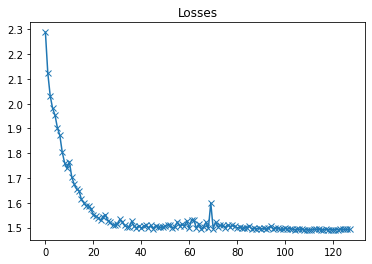

In [ ]:
plot(losses, 'Losses')

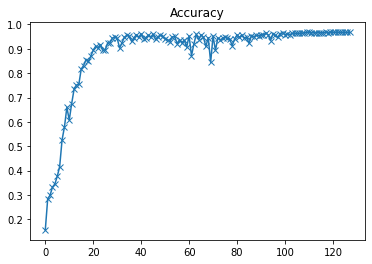

In [ ]:
plot(accuracies, 'Accuracy')

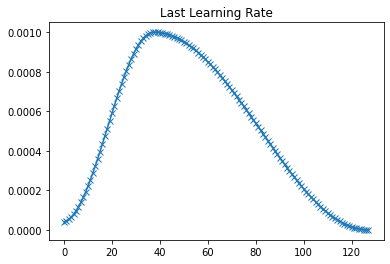

In [ ]:
plot(last_lr, 'Last Learning Rate')